In [15]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE
from csv_dtypes import column_dtypes

pd.set_option("display.max_rows", 60)  # default 60
pd.set_option("display.max_columns", 20)  # default 20

In [49]:
all_files = glob.glob("../roll_data/*-steal_attempt.csv")

df = pd.concat((pd.read_csv(f, dtype=column_dtypes) for f in all_files), ignore_index=True)

seasons = [11, 12]
# seasons = [11, 12, 13, 14]
# seasons = [13]
# seasons = [14]
df = df[df['season'].isin(seasons)]
len(df)

159959

In [50]:
df.loc[df["batter_name"].isna(),"batter_name"]

25077     <NA>
25078     <NA>
27150     <NA>
27154     <NA>
28188     <NA>
          ... 
260429    <NA>
260432    <NA>
264068    <NA>
264072    <NA>
265742    <NA>
Name: batter_name, Length: 504, dtype: string

In [71]:
def get_pitcher_mul(row):
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in pm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in pm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        # pass  # traveling just doesn't do anything on pitchers?
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
        # pass  # growth doesn't do anything on pitchers either
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    return mul


def get_batter_mul(row):
    # if row[["batter_name"]].isna().any():
        # row["batter_name"] == "NaaN"
    bm = str(row["batter_mods"])
    btm = str(row["batting_team_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    attrs = ""
    if "OVERPERFORMING" in bm:
        mul += 0.2
    if "OVERPERFORMING" in btm:
        mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    if "TRAVELING" in btm:
        if row["top_of_inning"]:
            # is this actually 0.035 instead of 0.05?
            mul += 0.35
    if "GROWTH" in btm:
        # is this actually 0.035 instead of 0.05?
        mul += min(0.05, 0.05 * (row["day"] / 99))
        # pass
    if "HIGH_PRESSURE" in btm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "SINKING_SHIP" in btm:
        mul += (14 - row["batting_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in btm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "CHUNKY" in bm and row["weather"] == "Weather.PEANUTS":
        # todo: make this work if there's also, like, Overperforming active
        # it only should apply to "power" attrs
        mul += 1.0
        attrs = "batter_musclitude, batter_divinity, batter_ground_friction"
    if "SMOOTH" in bm and row["weather"] == "Weather.PEANUTS":
        # todo: make this work if there's also, like, Overperforming active
        # it only should apply to "speed" attrs
        # doing 80% because of evidence from the Spin Attack blessing that "speed"
        # boosts laserlikeness 80% of what it says the total boost is?
        mul += 0.80
        attrs = "batter_musclitude, batter_laserlikeness, batter_ground_friction, batter_continuation"
    if "ON_FIRE" in bm:
        # todo: handle
        # test "+125% multiplier"
        mul += 1.25
        # pass
    # NVGs real??? eclipse weather, special case for Sutton Dreamy
    # surely this will not break from scattering, right? (It totally will)
    # if row["batter_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        # mul += 0.50
    return mul, attrs

def get_fielder_mul(row):
    fm = str(row["fielder_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in fm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in fm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        # pass
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == 18 and str(row["baserunner_count"]) > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "SHELLED" in fm:
        # is it this, or is it "mul = 0", I wonder
        mul -= 1.0
    # if row["fielder_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        # mul += 0.50
    return mul


In [72]:
pd.set_option("display.max_rows", 60)  # default 60
df.loc[25077]

event_type                 StealAttempt2
roll                            0.567968
passed                             False
batter_buoyancy                 0.655365
batter_divinity                 0.746182
                               ...      
fielder_roll                    0.335824
batter_consecutive_hits                1
batter_mul                           1.0
batter_mul_attrs                        
pitcher_mul                          1.0
Name: 25077, Length: 150, dtype: object

In [73]:
# df["batter_mul"] = df.apply(get_batter_mul, axis=1)
df[["batter_mul", "batter_mul_attrs"]] = df.apply(get_batter_mul, axis=1, result_type="expand")
df["pitcher_mul"] = df.apply(get_pitcher_mul, axis=1)
df["fielder_mul"] = df.apply(get_fielder_mul, axis=1)

In [74]:
# df["baserunner_n"] = [int(np.floor(len(x) / 40)) for x in df.loc[:, "baserunner_count"]]

df.loc[df["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
df.loc[df["batter_mods"].astype(str).str.contains("SCATTERED"), "batter_vibes"] = 0
df.loc[df["fielder_mods"].astype(str).str.contains("SCATTERED"), "fielder_vibes"] = 0

In [75]:
for attr in [
    "batter_buoyancy",
    "batter_divinity",
    "batter_martyrdom",
    "batter_moxie",
    "batter_musclitude",
    "batter_thwackability",
    "batter_coldness",
    "batter_overpowerment",
    "batter_ruthlessness",
    "batter_shakespearianism",
    "batter_suppression",
    "batter_unthwackability",
    "batter_base_thirst",
    "batter_continuation",
    "batter_ground_friction",
    "batter_indulgence",
    "batter_laserlikeness",
    "batter_anticapitalism",
    "batter_chasiness",
    "batter_omniscience",
    "batter_tenaciousness",
    "batter_watchfulness",
    "batter_pressurization",
    "batter_cinnamon",
]:
    # had to do all this to make chunky and smooth work correctly
    df[attr+"_mul_vibe"] = df.apply(lambda x: x[attr] * x["batter_mul"] * (1 + 0.2 * x["batter_vibes"])
                                  if (x["batter_mul_attrs"] == "") or (attr in x["batter_mul_attrs"])
                                  else x[attr] * (1 + 0.2 * x["batter_vibes"]),
                                  axis=1)
for attr in [
    "batter_patheticism",
    "batter_tragicness",
]:
    # had to do all this to make chunky and smooth work correctly
    df[attr+"_mul_vibe"] = df.apply(lambda x: x[attr] / x["batter_mul"] * (1 + 0.2 * x["batter_vibes"])
                                  if (x["batter_mul_attrs"] == "") or (attr in x["batter_mul_attrs"])
                                  else x[attr] * (1 + 0.2 * x["batter_vibes"]),
                                  axis=1)
    # df[attr + "_mul_vibe"] = df[attr] * df["batter_mul"] * (1 + 0.2 * df["batter_vibes"])

In [76]:
df = df.copy()
for attr in [
    "pitcher_buoyancy",
    "pitcher_divinity",
    "pitcher_martyrdom",
    "pitcher_moxie",
    "pitcher_musclitude",
    "pitcher_patheticism",
    "pitcher_thwackability",
    "pitcher_tragicness",
    "pitcher_ruthlessness",
    "pitcher_overpowerment",
    "pitcher_unthwackability",
    "pitcher_shakespearianism",
    "pitcher_suppression",
    "pitcher_coldness",
    "pitcher_base_thirst",
    "pitcher_continuation",
    "pitcher_ground_friction",
    "pitcher_indulgence",
    "pitcher_laserlikeness",
    "pitcher_anticapitalism",
    "pitcher_chasiness",
    "pitcher_omniscience",
    "pitcher_tenaciousness",
    "pitcher_watchfulness",
    "pitcher_pressurization",
    "pitcher_cinnamon",
]:
    # df[attr+"_mul_vibe"] = df.apply(lambda x: x[attr] * x["pitcher_mul"] * (1 + 0.2 * df["pitcher_vibes"])
    #                           if (x["pitcher_mul_attrs"] == "") or (attr in x["pitcher_mul_attrs"])
    #                           else x[attr] * (1 + 0.2 * df["pitcher_vibes"]),
    #                           axis=1)
    df[attr + "_mul_vibe"] = df[attr] * df["pitcher_mul"] * (1 + 0.2 * df["pitcher_vibes"])

In [707]:
if "fielder_vibes" in df:
    for attr in [
        "fielder_anticapitalism",
        "fielder_chasiness",
        "fielder_omniscience",
        "fielder_tenaciousness",
        "fielder_watchfulness",
    ]:
        # df[attr+"_mul_vibe"] = df.apply(lambda x: x[attr] * x["fielder_mul"] * (1 + 0.2 * df["fielder_vibes"])
        #                       if (x["fielder_mul_attrs"] == "") or (attr in x["fielder_mul_attrs"])
        #                       else x[attr] * (1 + 0.2 * df["fielder_vibes"]),
        #                       axis=1)
        df[attr + "_mul_vibe"] = df[attr] * df["fielder_mul"] * (1 + 0.2 * df["fielder_vibes"])

df = df.copy()

In [708]:
df.groupby("event_type").size().sort_values(ascending=False)[0:15]

event_type
StealAttempt0    81029
StealAttempt1    40366
StealAttempt2    38564
dtype: int64

In [1601]:
dfc = df[df["event_type"] == "StealAttempt0"].copy()
# for exclude_mod in ["OVERPERFORMING", "UNDERPERFORMING", "HIGH_PRESSURE",
#                     "GROWTH", "SINKING_SHIP", "TRAVELING"]:
# for exclude_mod in ["FLINCH", "O_NO", "ON_FIRE", "GROWTH", "TRAVELING"]:
# for exclude_mod in ["SPICY", "ON_FIRE"]:
# dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
#  dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
#  dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
#  dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

# dfc["laser_thirst"] = dfc["batter_laserlikeness_mul_vibe"] * dfc["batter_base_thirst_mul_vibe"]
dfc["laser_thirst"] = dfc["batter_laserlikeness_mul_vibe"] * dfc["batter_base_thirst"]
# dfc["laser_thirst"] = dfc["batter_laserlikeness"] * dfc["batter_base_thirst"]


dfc = dfc[(dfc["pitcher_mul"] == 1) & (dfc["batter_mul"] == 1) & (dfc["fielder_mul"] == 1)].copy()

dfc = dfc[dfc["stadium_id"].isna()].copy()

dfc = dfc[dfc["roll"] > 0.001].copy()

dfc["roll_log"] = np.log(dfc["roll"])
dfc["lt_log"] = np.log(dfc["laser_thirst"])
dfc["laser_log"] = np.log(dfc["batter_laserlikeness"])
dfc["thirst_log"] = np.log(dfc["batter_base_thirst"])

dfc["watch"] = (
    # 3 * dfc["pitcher_watchfulness_mul_vibe"]
    # + 1 * dfc["fielder_watchfulness_mul_vibe"]
    3 * dfc["pitcher_watchfulness"]
    + 1 * dfc["fielder_watchfulness"]
) / 1
dfc["watch_log"] = np.log(dfc["watch"])
dfc["watch_pow"] = dfc["watch"]**1.5
dfc["lt_pow"] = dfc["laser_thirst"]**1.5

# dfc = dfc[dfc["laser_thirst"] > 1e-3].copy()
len(dfc)
dfc["laser_thirst"].min()
# dfc.groupby("ballpark_inconvenience").size()

9.363319477201092e-07

In [1602]:
### Iterating a fit...
# fitting to laser_thirst and watch
# [0.03823398]
# (0.12963858063456313, 'laser_thirst')
# (-0.08346479052027601, 'watch')
dfc["combined"] = 0.12*dfc["laser_thirst"] - 0.02*dfc["watch"]
# dfc["combined_log"] = np.log(dfc["combined"])
# dfc = dfc[~dfc["combined_log"].isna()].copy()
# fitting roll_log to combined_log gives me this:
# [-1.20011315]
# (0.41525631384982287, 'combined_log')
# and it doesn't seem that great? idk...but...
dfc["combined_pow"] = dfc["combined"]**0.4
# fit is bad, it's definitely the wrong power.

# fitting roll_log to laser_log and thirst_log gives me:
# intercept: -2.467090405417344
# (1.2288955585926205, 'laser_log')
# (0.7401914421496469, 'thirst_log')
# there's a definite dependence on watch that isn't in here yet, but...
# what if i redefine laser_thirst...
dfc["laser_thirst_2"] = (
    dfc["batter_laserlikeness"]**1.5
    * dfc["batter_base_thirst"]**1
    * (1 + 0.2 * dfc["batter_vibes"])
)

dfc["laser_thirst_3"] = (
    dfc["batter_laserlikeness"]**1.5
    * dfc["batter_base_thirst"]**1.0
    * (1 + 0.2 * dfc["batter_vibes"])**1.0
)
dfc["lt3_log"] = np.log(dfc["laser_thirst_3"])

# lt_2 gives me a better fit...
# intercept: 0.038309967864791565
# (0.1315398571140168, 'laser_thirst_2')
# (-0.021317857978842874, 'watch')
# where watch is a 3:1 ratio of pitcher to fielder watchfulness
# so if i add the watch factor to roll, and do another log...
dfc["roll_adj"] = dfc["roll"] + 0.02 * dfc["watch"] - 0.05
dfc["roll_adj_log"] = np.log(dfc["roll_adj"])
dfc["vibe_log"] = np.log((1 + 0.2 * dfc["batter_vibes"]))

dfc["combined"] = 0.12*dfc["laser_thirst_2"] - 0.02*dfc["watch"]

# idea from astrid: (laser + thirst)**power
dfc["l_plus_t"] = (dfc["batter_laserlikeness_mul_vibe"] + dfc["batter_base_thirst_mul_vibe"])
dfc["l_plus_t_log"] = np.log(dfc["l_plus_t"])

/Users/robbyblum/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


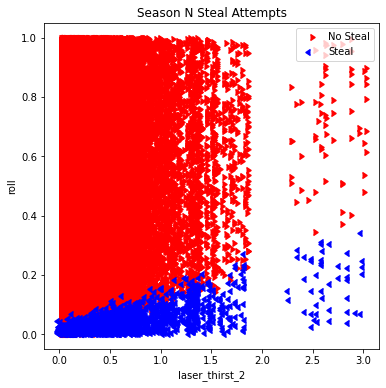

In [1603]:
y_val = "roll"
x_val = "laser_thirst_2"
# x_val = "combined"
fig, ax = plt.subplots(1, figsize=(6, 6))
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]][y_val],
    color="red",
    label="No Steal",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]][y_val],
    color="blue",
    label="Steal",
    marker=CARETLEFTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
ax.set_title(f"Season N Steal Attempts")
# ax.set_xlim(0.484, 0.499)
# ax.set_ylim(-0.2, 0.2)

# if x_val == "threshold":
# ax.plot(ax.get_xlim(), 1.5*np.array(ax.get_xlim()))

ax.legend()

In [1604]:
X = dfc[
    [
        "passed",
        # "roll",
        # "roll_corr",
        # "roll_log",
        # "roll_corr_log",
        # "roll_adj",
        "roll_adj_log",
        # "combined",
        # "combined_log",
        # "combined_pow",
        # "laser_thirst",
        # "laser_thirst_2",
        # "laser_thirst_3",
        # "lt3_log",
        "laser_log",
        "thirst_log",
        # "l_plus_t",
        # "batter_laserlikeness_mul_vibe",
        # "batter_base_thirst_mul_vibe",
        # "l_plus_t_log",
        # "lt_log",
        # "lt_pow",
        # "watch",
        # "pitcher_watchfulness",
        # "fielder_watchfulness",
        # "pitcher_anticapitalism",
        # "fielder_anticapitalism",
        # "watch_log",
        # "watch_pow",
        # "ballpark_inconvenience",
        # 'ballpark_elongation',
        # "batter_vibes",
        "vibe_log",
    ]
]
# X = X[X['roll'] < 0.85]
X = X[~X["roll_adj_log"].isna()]
y = X["passed"]
y=y.astype('int')
X = X.drop("passed", axis=1)

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

# # trainedsvm = svm.SVC(kernel='linear').fit(X, y)
# trainedsvm = svm.LinearSVC(dual=False, max_iter=100000).fit(X, y)
# predictionsvm = trainedsvm.predict(X)
# print(confusion_matrix(y,predictionsvm))
# print(classification_report(y,predictionsvm))

pin_intercept = np.log(0.12)
# pin_intercept = None
pins = [
    # (1.5, "laser_log"),
    # (1.1, "thirst_log"),
    # (0.12, "laser_thirst_2"),
    # (-0.02, "watch"),
]
for val, var in pins:
    X["roll_adj_log"] -= X[var] * val
    X = X.drop(var, axis=1)

sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:,0] -= pin_intercept / sc.scale_[0]

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=100000000, tol=1e-12,
                           fit_intercept=pin_intercept is None).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
# print(len(dfc[~dfc["passed"]]))
# print(len(dfc[dfc["passed"]]))
print(confusion_matrix(y, predictionsvm))
print(confusion_matrix(y, predictionsvm)[0,1] + confusion_matrix(y, predictionsvm)[1,0], "outliers")
print(trainedsvm.score(X2, y))

coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_# - np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept

dfc["threshold"] = intercept_scaled
print("intercept:", intercept_scaled)
for pair in pins + list(zip(-np.array(coef_list), X.columns)):
    if "roll" not in pair[1]:
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]

[[51000   129]
 [   98  1579]]
227 outliers
0.9957012460705222
intercept: -2.120263536200091
(1.5077552772995761, 'laser_log')
(1.1440382410722898, 'thirst_log')
(1.6082663437167255, 'vibe_log')


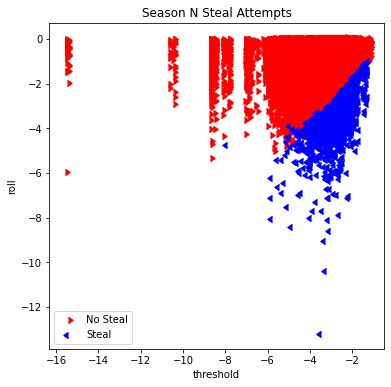

In [1594]:
# dfc["threshold"] = intercept_scaled[0]
# print("intercept:", intercept_scaled)
# for pair in pins + list(zip(-np.array(coef_list), X.columns)):
#     if "roll" not in pair[1]:
#         print(pair)
#         dfc["threshold"] += pair[0] * dfc[pair[1]]
        
y_val = "roll_adj_log"
x_val = "threshold"
# x_val = "watch"
fig, ax = plt.subplots(1, figsize=(6, 6))
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]][y_val],
    color="red",
    label="No Steal",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]][y_val],
    color="blue",
    label="Steal",
    marker=CARETLEFTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
ax.set_title(f"Season N Steal Attempts")
# ax.set_xlim(0.484, 0.499)
# ax.set_ylim(-0.01, 0.01)
# ax.set_xlim(-0.1, 0.1)
# ax.set_yscale("log")
# ax.set_xscale("log")
# if x_val == "threshold":
    # ax.plot(ax.get_ylim(), ax.get_ylim())

ax.legend()

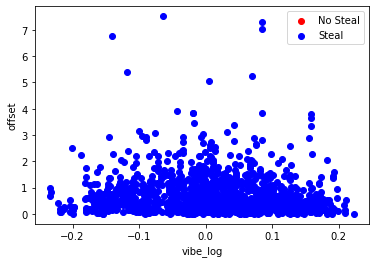

In [1588]:
dfc["offset"] = dfc["roll_adj_log"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]

fig, ax = plt.subplots(1)
x_val = "threshold"
# x_val = "batter_base_thirst"
# x_val = "batter_laserlikeness"
x_val = "vibe_log"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="No Steal",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Steal",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()
# ax.set_ylim(0,2)

In [1435]:
# pd.set_option("display.max_rows", None)  # default 60
pd.set_option("display.max_columns", 20)  # default 20
table = outliers[
    [
        "passed",
        "offset",
        "roll",
        "threshold",
        # "event_type",  # "home_score", "away_score", "top_of_inning", "inning",
        "pitcher_mul",
        "batter_mul",
        "fielder_mul",  # "baserunner_count",
        # "batter_vibes", "pitcher_vibes",
        "laser_thirst",
        "pitcher_watchfulness_mul_vibe",
        "fielder_watchfulness_mul_vibe",
        "ballpark_inconvenience",
        "batter_name",
        "pitcher_name",
        "fielder_name",
        "batter_mods",
        "pitcher_mods",
        "fielder_mods",
        "batting_team_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
        # "fielder_roll",
    ]
]
print(len(table))
table.sort_values("offset", ascending=False)#[0:10]

2042


,passed,offset,roll,threshold,pitcher_mul,batter_mul,fielder_mul,laser_thirst,pitcher_watchfulness_mul_vibe,fielder_watchfulness_mul_vibe,...,fielder_name,batter_mods,pitcher_mods,fielder_mods,batting_team_mods,pitching_team_mods,season,day,game_id,play_count
217617,True,2.072102,0.018796,-2.053306,1.0,1.0,1.0,0.008592,0.231868,0.329156,...,Helga Burton,<NA>,<NA>,<NA>,O_NO,LOVE;EXTRA_STRIKE;BASE_DEALING,12,34,4ecd3a7d-d831-4a68-9569-c87b4f5222a2,419
81560,True,2.065933,0.025814,-2.040119,1.0,1.0,1.0,0.007122,0.134625,0.027384,...,Sutton Dreamy,<NA>,WILD;FRIEND_OF_CROWS;FLIICKERRRIIING;SQUIDDISH,FLINCH,O_NO,<NA>,12,17,97fe7217-d383-454f-b83f-adbf99923114,12
124049,True,2.038651,0.024227,-2.014424,1.0,1.0,1.0,0.008054,0.086412,0.000897,...,<NA>,<NA>,<NA>,FLICKERING;RECEIVER,O_NO,BIRD_SEED,12,57,0b6ff98f-c9b1-4d1f-bedf-1a050a097213,106
162456,True,2.028203,0.003855,-2.024348,1.0,1.0,1.0,0.021297,0.714353,0.066478,...,Raúl Leal,<NA>,<NA>,<NA>,FIREPROOF;SEALANT,LIFE_OF_PARTY;ELECTRIC,11,71,d3c55c79-04be-4a2e-9096-c2c9c9364c65,141
72650,True,2.007898,0.009472,-1.998426,1.0,1.0,1.0,0.021811,0.358920,0.453083,...,Freemium Seraph,<NA>,<NA>,<NA>,FIREPROOF;SEALANT;AMBUSH,<NA>,12,26,ce349cb3-8b16-474a-9827-4d532810e33a,107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214523,True,0.071579,0.204958,0.133379,1.0,1.0,1.0,2.611587,0.466471,0.263007,...,Nandy Fantastic,<NA>,<NA>,FIRST_BORN,<NA>,BIRD_SEED,12,32,996e5d19-a3f6-410d-8f1e-8c405b7cc7e6,198
232300,True,0.069840,0.122065,0.052225,1.0,1.0,1.0,2.270886,0.457569,0.035924,...,Alx Keming,FLINCH,WILD;PERK,<NA>,CARCINIZATION;EXTRA_STRIKE,TRAVELING;EXTRA_STRIKE,12,48,ff465b3d-cb6b-4ef6-9658-83ca6688c7f2,85
83240,True,0.064240,0.042167,-0.022073,1.0,1.0,1.0,2.226372,0.437145,0.264727,...,Nandy Fantastic,FLINCH,<NA>,FIRST_BORN,CARCINIZATION;EXTRA_STRIKE,BIRD_SEED,12,18,7809d346-0934-47cd-a75e-ef589a12ec6c,282
217883,True,0.040718,0.076102,0.035384,1.0,1.0,1.0,2.486115,0.270696,0.654629,...,Mira Lemma,<NA>,<NA>,<NA>,<NA>,MAINTENANCE_MODE,12,35,f19fd7ee-5ab1-4ee2-8ade-19c56735183d,78


In [ ]:
# outliers.sort_values('roll', ascending=True).style.hide()
dfc.groupby("fielder_name").size().sort_values(ascending=False)[0:5]

In [ ]:
dfc.corr()["offset"].sort_values()[0:10]

In [ ]:
plt.rcParams["font.size"] = 10
x_val = "threshold"
fig, axes = plt.subplots(3, 2, figsize=(10, 15), constrained_layout=True)
# fig.suptitle(f"Season {season+1} Hits vs. Outs", fontsize=16)
dimlist = [5e-2, 2e-2, 1e-2, 0.5e-2, 0.2e-2, 0.1e-2]
for i, ax in enumerate(np.ravel(axes)):
    ax.scatter(
        dfc[dfc["passed"]][x_val],
        dfc[dfc["passed"]]["offset"],
        color="blue",
        label="Steal",
    )
    ax.scatter(
        dfc[~dfc["passed"]][x_val],
        dfc[~dfc["passed"]]["offset"],
        color="red",
        label="No Steal",
    )
    ax.scatter(
        outliers[~outliers["passed"]][x_val],
        outliers[~outliers["passed"]]["offset"],
        color="red",
        edgecolor="black",
    )
    ax.scatter(
        outliers[outliers["passed"]][x_val],
        outliers[outliers["passed"]]["offset"],
        color="blue",
        edgecolor="black",
    )
    ax.set_xlabel(x_val)
    ax.set_ylabel("offset")
    ax.legend()
    ax.grid()
    ax.set_ylim(-dimlist[i], dimlist[i])
# fig.savefig("../figures/hit_out_fit_offsets.png", facecolor='white')

## Best formulas so far

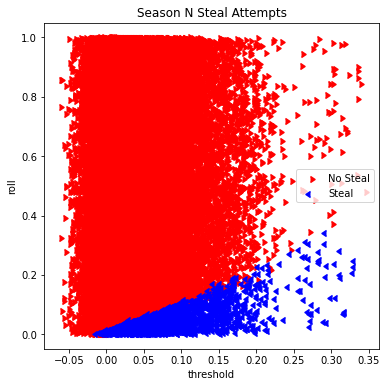

In [1108]:
# dfc["threshold"] = 0.075 - (
#     -0.131 * dfc["laser_thirst"]
#     + 0.06 * dfc["pitcher_watchfulness_mul_vibe"]
#     + 0.02 * dfc["fielder_watchfulness_mul_vibe"]
#     + 0.055 * dfc["ballpark_elongation"]
#     + 0.05 * dfc["ballpark_inconvenience"]
# )

# # this will usethe fit values
# dfc["threshold"] = -intercept_scaled[0]
# print(-intercept_scaled)
# for pair in zip(-np.array(coef_list), X.columns):
#     if pair[1] not in ["roll", "roll_log", "roll_corr"]:
#         print(pair)
#         dfc["threshold"] += pair[0] * dfc[pair[1]]


y_val = "roll"
x_val = "threshold"
# x_val = "laser_log"
fig, ax = plt.subplots(1, figsize=(6, 6))
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]][y_val],
    color="red",
    label="No Steal",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]][y_val],
    color="blue",
    label="Steal",
    marker=CARETLEFTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
ax.set_title(f"Season N Steal Attempts")
# ax.set_xlim(0.484, 0.499)
# ax.set_ylim(0, 0.5)

# if x_val == "threshold":
    # ax.plot(ax.get_xlim(), ax.get_xlim())

ax.legend()

##### Unrelated stuff

In [34]:
def calc_vibes(df, prefix):
    buoy = df[prefix + "_buoyancy"]
    press = df[prefix + "_pressurization"]
    cinn = df[prefix + "_cinnamon"]

    period = 6 + (buoy * 10).round()
    phase = np.pi * ((2 / period) * df["day"] + 0.5)
    vibes = 0.5 * (press + cinn) * np.sin(phase) - (0.5 * press) + (0.5 * cinn)
    return vibes

In [43]:
foo = pd.DataFrame({"dunlap_buoyancy": 0.862,
                    "dunlap_pressurization": 0.935,
                    # "dunlap_cinnamon": 1.121,
                    "dunlap_cinnamon": 0.971,
                    "bertie_buoyancy": 0.198,
                    "bertie_pressurization": 0.689,
                    "bertie_cinnamon": 0.022,
                    "bertie_s8_buoyancy": 0.298,
                    "bertie_s8_pressurization": 0.689,
                    "bertie_s8_cinnamon": 0.022,
                    "day": np.arange(116)})

In [44]:
foo["dunlap_vibes"] = calc_vibes(foo, "dunlap")
foo["bertie_vibes"] = calc_vibes(foo, "bertie")
foo["bertie_s8_vibes"] = calc_vibes(foo, "bertie_s8")

Text(0.5, 1.0, "Dunlap's Vibes, season 4")

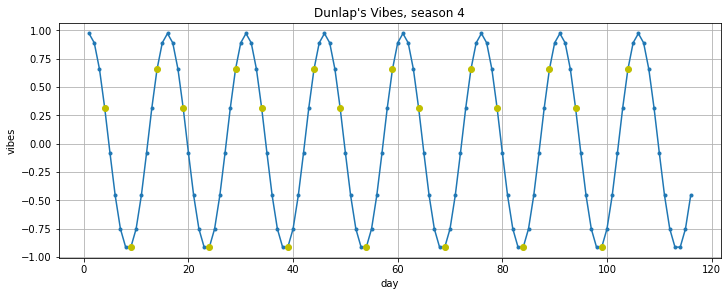

In [48]:
plt.figure(figsize=(10,4), layout="constrained")
plt.plot(foo["day"][:116]+1, foo["dunlap_vibes"][:116], '.-')
plt.plot(foo["day"][3:99:5]+1, foo["dunlap_vibes"][3:99:5], 'yo')
plt.plot(foo["day"][103]+1, foo["dunlap_vibes"][103], 'yo')
plt.xlabel("day")
plt.ylabel("vibes")
plt.grid()
plt.title("Dunlap's Vibes, season 4")
# plt.xlim(1,15)
# plt.ylim(-1,1)

(-1.0, 1.0)

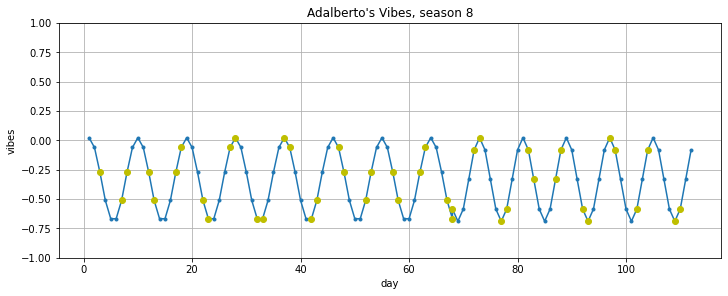

In [37]:
s8_day = np.array(foo["day"][:68]+1)
s8_day = np.append(s8_day, (foo["day"][67:]+1))
s8_vibes = np.array(foo["bertie_s8_vibes"][:68])
s8_vibes = np.append(s8_vibes, (foo["bertie_vibes"][67:]))
plt.figure(figsize=(10,4), layout="constrained")
plt.plot(s8_day[:113], s8_vibes[:113], '.-')
plt.plot(s8_day[2:68:5], s8_vibes[2:68:5], 'yo')
plt.plot(s8_day[6:68:5], s8_vibes[6:68:5], 'yo')
plt.plot(s8_day[68:99:5], s8_vibes[68:99:5], 'yo')
plt.plot(s8_day[72:99:5], s8_vibes[72:99:5], 'yo')
plt.plot(s8_day[102], s8_vibes[102], 'yo')
plt.plot(s8_day[104], s8_vibes[104], 'yo')
plt.plot(s8_day[109], s8_vibes[109], 'yo')
plt.plot(s8_day[110], s8_vibes[110], 'yo')

plt.xlabel("day")
plt.ylabel("vibes")
plt.grid()
plt.title("Adalberto's Vibes, season 8")
# plt.xlim(1,15)
plt.ylim(-1,1)
# print(s8_day[2:68:5], s8_day[68:99:5])
# print(s8_day[6:68:5], s8_day[72:99:5])

(-1.0, 1.0)

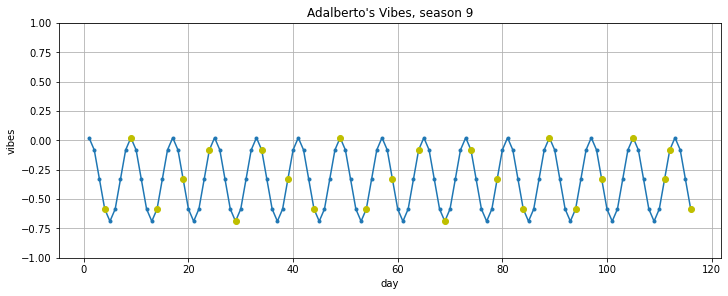

In [38]:
plt.figure(figsize=(10,4), layout="constrained")
plt.plot(foo["day"][:116]+1, foo["bertie_vibes"][:116], '.-')
plt.plot(foo["day"][3:99:5]+1, foo["bertie_vibes"][3:99:5], 'yo')
plt.plot(foo["day"][104]+1, foo["bertie_vibes"][104], 'yo')
plt.plot(foo["day"][110]+1, foo["bertie_vibes"][110], 'yo')
plt.plot(foo["day"][111]+1, foo["bertie_vibes"][111], 'yo')
plt.plot(foo["day"][115]+1, foo["bertie_vibes"][115], 'yo')
plt.xlabel("day")
plt.ylabel("vibes")
plt.grid()
plt.title("Adalberto's Vibes, season 9")
# plt.xlim(1,15)
plt.ylim(-1,1)

(-1.0, 1.0)

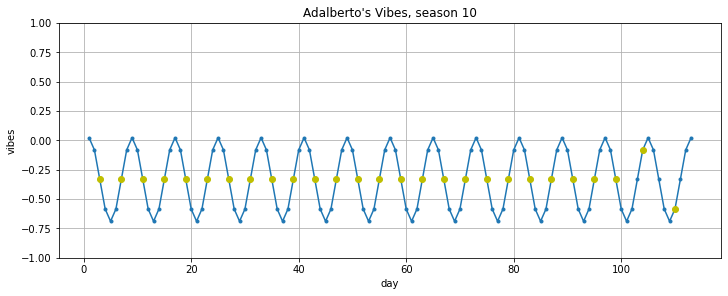

In [39]:
plt.figure(figsize=(10,4), layout="constrained")
plt.plot(foo["day"][:113]+1, foo["bertie_vibes"][:113], '.-')
plt.plot(foo["day"][2:99:4]+1, foo["bertie_vibes"][2:99:4], 'yo')
plt.plot(foo["day"][103]+1, foo["bertie_vibes"][103], 'yo')
plt.plot(foo["day"][109]+1, foo["bertie_vibes"][109], 'yo')
plt.xlabel("day")
plt.ylabel("vibes")
plt.grid()
plt.title("Adalberto's Vibes, season 10")
# plt.xlim(1,15)
plt.ylim(-1,1)